In [3]:
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

##################  Загрузка данных
Xtrain = pd.read_csv('D:\Coding\data\phone_user_review_file_60.csv', encoding= 'utf-8')
Xtest = pd.read_csv('D:\Coding\data\phone_user_review_file_40.csv', encoding= 'utf-8')

In [5]:
print("Xtrain.shape(): ", Xtrain.shape,
      "\nXtest.shape(): ", Xtest.shape)

Xtrain.shape():  (163837, 11) 
Xtest.shape():  (98284, 11)


In [6]:
print("Xtrain.head():\n", Xtrain[['lang', 'score', 'extract']].head())

Xtrain.head():
   lang  score                                            extract
0   en    8.0  I've had the phone for awhile and it's a prett...
1   en    6.0  to be clear it is not the sellers fault that t...
2   en    9.0  Well i love this phone. i have had ton of phon...
3   en    4.0  I have had my Instinct for several months now ...
4   en    6.0  i have had this instinct phone for about two m...


In [ ]:
##################  Препроцессинг

In [7]:
import nltk
nltk.download('stopwords')
from sklearn.metrics import mean_squared_error
import re #regular expressions
from nltk.corpus import stopwords #stopwords

import pymorphy2 #Для лемматизации
morph = pymorphy2.MorphAnalyzer()

#Добавление списка stopwords
stops = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Алексей\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def review_to_wordlist(review):
    #1) - регулярное выражение к тексту
    review_text = re.sub("[^а-яА-Яa-zA-Z]"," ", review)
    #2) - разделение текста на список слов
    words = review_text.lower().split()
    #3) - удаление stopwords из списка слов
    words = [w for w in words if not w in stops]
    #4) - лемматизация слов
    #words = [morph.parse(w)[0].normal_form for w in words ]
    return(words)

In [9]:
# Преобразуем время
# Разделение времени на год и месяц
Xtrain['date'] = Xtrain['date'].apply(pd.to_datetime)
Xtrain['year'] = Xtrain['date'].apply(lambda x: x.year)
Xtrain['month'] = Xtrain['date'].apply(lambda x: x.month)

In [10]:
#Валидация на 2016 годе
Xtr = Xtrain[(Xtrain['year']==2015) & (Xtrain.lang == 'en')].head(200)
Xval = Xtrain[(Xtrain['year']==2016) & (Xtrain.lang == 'en')].head(50)
#score - оценка телефона
ytr = Xtr['score']
yval = Xval['score']

In [11]:
print("Xtr.shape(): ", Xtr.shape,
      "\nXval.shape(): ", Xval.shape,
      "\nytr.mean(): ", ytr.mean(),
      "\nyval.mean(): ", yval.mean()
      )

Xtr.shape():  (200, 13) 
Xval.shape():  (50, 13) 
ytr.mean():  7.925 
yval.mean():  8.22


In [12]:
data = pd.concat([Xtr,Xval],axis = 0,ignore_index = True)

#у нас есть nan, поэтому преобразуем их к строке
data['content_clear'] = data['extract'].apply(str)
data['content_clear'] = data['content_clear'].apply(review_to_wordlist)

In [13]:
print("1-й комментрий: \ndata['content_clear'][0]: ", data['content_clear'][0])

1-й комментрий: 
data['content_clear'][0]:  ['price', 'expected', 'phone', 'beat', 'work']


############## Word2vec ##############

In [14]:
from gensim.models import word2vec
from multiprocessing import cpu_count

######## Тренировка модели
# size - размер вектора
#min_count - игнорирует все слова с total frequency меньше заданного значения
#workers - количество ядер PC
#window - максимальная дистанция между текущем словом и прогнозируемом в предложении

model_w2v = word2vec.Word2Vec(data['content_clear'], size=50, window=10, workers=cpu_count())
w2v = dict(zip(model_w2v.wv.index2word, model_w2v.wv.syn0))

In [18]:
# Посмотрим чему выучилась модель:
model_w2v.wv.most_similar(positive=['phone'])

[('price', 0.6293317675590515),
 ('smooth', 0.6030991077423096),
 ('good', 0.5598933696746826),
 ('expected', 0.5186594128608704),
 ('used', 0.49390512704849243),
 ('one', 0.48948007822036743),
 ('fast', 0.4750627279281616),
 ('product', 0.47186216711997986),
 ('amazing', 0.4704839885234833),
 ('home', 0.4695117473602295)]

############## mean_vectorizer ##############

In [19]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v.values())))

    def fit(self, X):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [20]:
data_mean = mean_vectorizer(w2v).fit(data['content_clear']).transform(data['content_clear'])
data_mean.shape

(250, 50)

In [21]:
def split(train,y,ratio):
    idx = ratio
    return train[:idx, :], train[idx:, :], y[:idx], y[idx:]
y = data['score']
Xtr, Xval, ytr, yval = split(data_mean, y,200)

In [22]:
print("Xtr.shape(): ", Xtr.shape,
      "\nXval.shape(): ", Xval.shape,
      "\nytr.mean(): ", ytr.mean(),
      "\nyval.mean(): ", yval.mean()
      )

Xtr.shape():  (200, 50) 
Xval.shape():  (50, 50) 
ytr.mean():  7.925 
yval.mean():  8.22


In [23]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
model_ridge_01 = Ridge(alpha = 1,random_state=7)
model_ridge_01.fit(Xtr, ytr)
train_preds = model_ridge_01.predict(Xtr)
valid_preds = model_ridge_01.predict(Xval)
ymed = np.ones(len(valid_preds))*ytr.median()
print('Ошибка на трейне',mean_squared_error(ytr, train_preds))
print('Ошибка на валидации',mean_squared_error(yval, valid_preds))
print('Ошибка на валидации предсказываем медиану',mean_squared_error(yval, ymed))

Ошибка на трейне 7.16345328985753
Ошибка на валидации 6.337549684390984
Ошибка на валидации предсказываем медиану 6.3


############## tfidf преобразование ##############

In [24]:
#пропишем класс выполняющий tfidf преобразование.
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

class tfidf_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(next(iter(w2v.values())))

    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [25]:
data_mean_tfidf = tfidf_vectorizer(w2v).fit(data['content_clear']).transform(data['content_clear'])
print("data_mean_tfidf.shape: ", data_mean_tfidf.shape)

data_mean_tfidf.shape:  (250, 50)


In [26]:
y = data['score']
Xtr, Xval, ytr, yval = split(data_mean_tfidf, y,200)

In [27]:
print("Xtr.shape(): ", Xtr.shape,
      "\nXval.shape(): ", Xval.shape,
      "\nytr.mean(): ", ytr.mean(),
      "\nyval.mean(): ", yval.mean()
      )


Xtr.shape():  (200, 50) 
Xval.shape():  (50, 50) 
ytr.mean():  7.925 
yval.mean():  8.22


In [28]:
model_ridge_02 = Ridge(alpha = 1,random_state=7)
model_ridge_02.fit(Xtr, ytr)
train_preds = model_ridge_02.predict(Xtr)
valid_preds = model_ridge_02.predict(Xval)
ymed = np.ones(len(valid_preds))*ytr.median()
print('Ошибка на трейне',mean_squared_error(ytr, train_preds))
print('Ошибка на валидации',mean_squared_error(yval, valid_preds))
print('Ошибка на валидации предсказываем медиану',mean_squared_error(yval, ymed))

Ошибка на трейне 7.078471483586543
Ошибка на валидации 6.353230115604405
Ошибка на валидации предсказываем медиану 6.3


############## Нейронная сеть ##############

In [29]:
# подключим библиотеки keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [30]:
# Опишем нашу сеть.
def baseline_model():
    model_neuraln = Sequential()
    model_neuraln.add(Dense(128, input_dim=Xtr.shape[1], kernel_initializer='normal', activation='relu'))
    model_neuraln.add(Dropout(0.2))
    model_neuraln.add(Dense(64, activation='relu'))
    model_neuraln.add(Dropout(0.5))
    model_neuraln.add(Dense(1, kernel_initializer='normal'))

    model_neuraln.compile(loss='mean_squared_error', optimizer='adam')
    return model_neuraln

In [31]:
estimator = KerasRegressor(build_fn=baseline_model,epochs=20, nb_epoch=20, batch_size=64,validation_data=(Xval, yval), verbose=2)
estimator.fit(Xtr, ytr)

Train on 200 samples, validate on 50 samples
Epoch 1/20
 - 1s - loss: 69.8631 - val_loss: 73.4747
Epoch 2/20
 - 0s - loss: 69.5248 - val_loss: 73.0344
Epoch 3/20
 - 0s - loss: 69.0725 - val_loss: 72.4351
Epoch 4/20
 - 0s - loss: 68.4018 - val_loss: 71.6445
Epoch 5/20
 - 0s - loss: 67.6287 - val_loss: 70.6098
Epoch 6/20
 - 0s - loss: 66.4954 - val_loss: 69.2637
Epoch 7/20
 - 0s - loss: 65.0629 - val_loss: 67.5160
Epoch 8/20
 - 0s - loss: 63.3038 - val_loss: 65.3226
Epoch 9/20
 - 0s - loss: 61.0869 - val_loss: 62.6234
Epoch 10/20
 - 0s - loss: 57.9167 - val_loss: 59.3562
Epoch 11/20
 - 0s - loss: 54.9482 - val_loss: 55.4730
Epoch 12/20
 - 0s - loss: 50.6073 - val_loss: 50.9733
Epoch 13/20
 - 0s - loss: 46.7854 - val_loss: 45.8390
Epoch 14/20
 - 0s - loss: 41.0492 - val_loss: 40.1228
Epoch 15/20
 - 0s - loss: 36.2790 - val_loss: 34.0826
Epoch 16/20
 - 0s - loss: 30.0742 - val_loss: 27.8519
Epoch 17/20
 - 0s - loss: 23.5476 - val_loss: 21.8328
Epoch 18/20
 - 0s - loss: 19.5219 - val_loss: 

############## Linear Regression ##############

In [32]:
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

linear_regression_01 = LinearRegression()
model = linear_regression_01.fit(Xtr, ytr)

predicted_Xtr = model.predict(Xtr)
predicted_Xval = model.predict(Xval)

print("\nПредсказанные моделью значения:\n", predicted_Xtr[:10])


Предсказанные моделью значения:
 [ 5.62071133  7.5394154  10.81896192  7.33440152  8.59684392  8.79293137
  7.55313844  8.78042725  5.58322179  6.9229608 ]


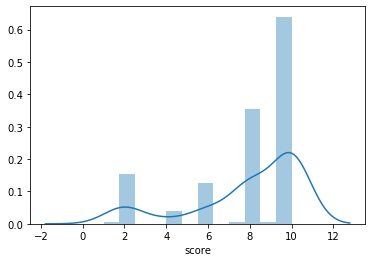

In [33]:
plt.figure(figsize=(6, 4))
sns.distplot(ytr)

plt.show()

In [34]:
########## Сревнение предсказания и реального значения (оценка модели)

predicted_truth_df = pd.DataFrame(list(zip(predicted_Xtr, ytr)))
predicted_truth_df.columns = ['Prediction', 'Ground truth']
print(predicted_truth_df.head())

   Prediction  Ground truth
0    5.620711           4.0
1    7.539415           6.0
2   10.818962          10.0
3    7.334402           2.0
4    8.596844          10.0


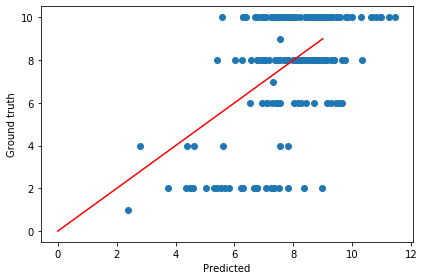

In [35]:
########## Scatter plot трейна (оценка модели)

plt.figure(figsize=(6, 4))
plt.scatter(predicted_Xtr, ytr)
plt.xlabel('Predicted')
plt.ylabel('Ground truth')

plt.plot([0, 9], [0, 9], color = "red")
plt.tight_layout()
plt.show()

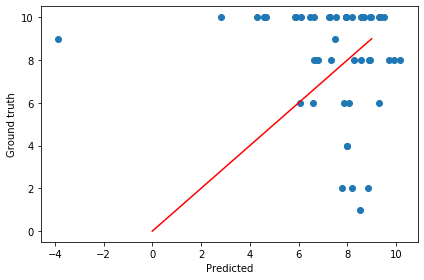

In [36]:
########## Scatter plot валидация (оценка модели)

plt.figure(figsize=(6, 4))
plt.scatter(predicted_Xval, yval)
plt.xlabel('Predicted')
plt.ylabel('Ground truth')

plt.plot([0, 9], [0, 9], color = "red")
plt.tight_layout()
plt.show()

In [37]:
ymed = np.ones(len(predicted_Xval))*ytr.median()
print('Ошибка на трейне',mean_squared_error(ytr, train_preds))
print('Ошибка на валидации',mean_squared_error(yval, valid_preds))
print('Ошибка на валидации предсказываем медиану',mean_squared_error(yval, ymed))

Ошибка на трейне 7.078471483586543
Ошибка на валидации 6.353230115604405
Ошибка на валидации предсказываем медиану 6.3


############## Random Forest ##############

In [38]:
y = data['score']
X_train, X_test, y_train, y_test = split(data_mean, y,200)

In [39]:
print("Xtr.shape(): ", X_train.shape,
      "\nXval.shape(): ", X_test.shape,
      "\nytr.mean(): ", y_train.mean(),
      "\nyval.mean(): ", y_test.mean()
      )

Xtr.shape():  (200, 50) 
Xval.shape():  (50, 50) 
ytr.mean():  7.925 
yval.mean():  8.22


In [40]:
from sklearn import tree
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from matplotlib.pylab import rcParams

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [41]:
from sklearn import utils

print(utils.multiclass.type_of_target(X_train))
print(utils.multiclass.type_of_target(y_train))

continuous-multioutput
multiclass


In [42]:
X_train = X_train.astype('int')
y_train = y_train.astype('int')
X_test = X_test.astype('int')
y_test = y_test.astype('int')

print(utils.multiclass.type_of_target(X_train))
print(utils.multiclass.type_of_target(y_train))

multilabel-indicator
multiclass


In [43]:
from sklearn.ensemble import RandomForestClassifier

#Random Forest классификатор
clf_rf = RandomForestClassifier()

#n_estimators - количество деревьев
parameters = {'n_estimators': [10, 20, 30], 'max_depth': [2, 5, 7, 10]}

In [44]:
#классификатор GridSearchCV
grid_search_cv_clf_rf = GridSearchCV(clf_rf, parameters, cv=5)
grid_search_cv_clf_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [45]:
print(
    '\nРекомендуемые параметры: ',
    grid_search_cv_clf_rf.best_params_ #выбор параметров, для которых значение accuracy будет максимальным на кросс-валидационном множестве, а не просто на обучающей выборке
)


Рекомендуемые параметры:  {'max_depth': 2, 'n_estimators': 10}


In [46]:
best_clf = grid_search_cv_clf_rf.best_estimator_

In [47]:
feature_importances = best_clf.feature_importances_

#Набор фичей, который показывает по каким из них нужно было сделать сплиты,
# чтобы добиться максимольного снижения энтропии данных
#feature_importances_df = pd.DataFrame({'features':list(X_train),
#                                       'feature_importances':feature_importances})
print(feature_importances)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [48]:
feature_importances_df = pd.DataFrame(list(zip(X_train, feature_importances)),
                                 columns = ['features', 'feature_importances'])

feature_importances_df = feature_importances_df.sort_values('feature_importances', ascending=False)

print('\nfeature_importances_df: \n', feature_importances_df)


feature_importances_df: 
                                              features  feature_importances
0   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                  0.0
37  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                  0.0
27  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                  0.0
28  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                  0.0
29  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                  0.0
30  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                  0.0
31  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                  0.0
32  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                  0.0
33  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                  0.0
34  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                  0.0
35  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                  0.0
36  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                  0.

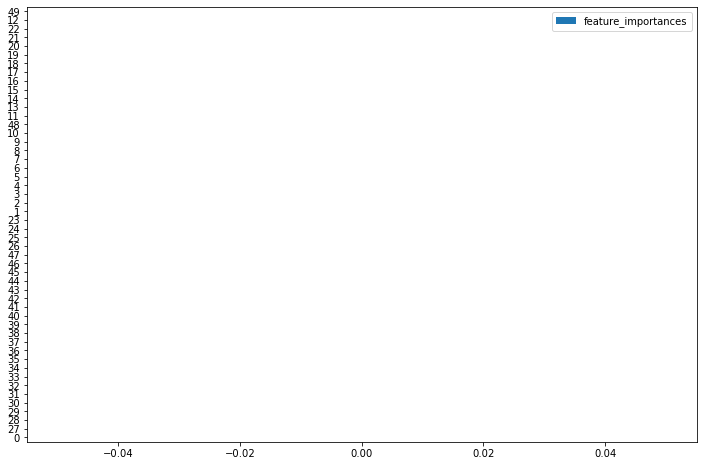

In [49]:
imp = pd.DataFrame(best_clf.feature_importances_, columns=['feature_importances'])
imp.sort_values('feature_importances').plot(kind='barh', figsize=(12, 8))
plt.show()